In [1]:
# Let's install ignite as a custom package:
#!pip install git+https://github.com/pytorch/ignite.git --prefix=/kaggle/working
    
import sys
sys.path.insert(0, "/kaggle/working/lib/python3.6/site-packages")

In [2]:
from pathlib import Path

import numpy as np
import time
import tqdm
import torch
import shutil
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, RandomResizedCrop, RandomVerticalFlip, RandomHorizontalFlip
from torchvision.transforms import ColorJitter, ToTensor, Normalize


FRUIT360_PATH = Path(".").resolve().parent/ "fruits-360"

img_size = 64

device = "cuda"
if not torch.cuda.is_available():
    device = "cpu"

train_transform = Compose([
    RandomHorizontalFlip(),    
    RandomResizedCrop(size=img_size),
    ColorJitter(brightness=0.12),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = Compose([
    RandomResizedCrop(size=img_size),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 128
num_workers = 10

train_dataset = ImageFolder((FRUIT360_PATH /"Training").as_posix(), transform=train_transform, target_transform=None)
val_dataset = ImageFolder((FRUIT360_PATH /"Test").as_posix(), transform=val_transform, target_transform=None)

pin_memory = "cuda" in device
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                          drop_last=True, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                        drop_last=False, pin_memory=pin_memory)


In [3]:
b = iter(val_loader).next()

In [4]:
data, labels = b

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/lizixing/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
imshow(data[0].numpy().transpose(1,2,0))
predictions=[0]*len(labels)
title("{}:{}".format(val_dataset.classes[labels[0]], val_dataset.classes[predictions[0]]));
text(0, 60, val_dataset.classes[labels[0]], color='r')

In [20]:
def show_batch(images, targets, predictions=None):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(data[i].numpy().transpose(1,2,0))
        text(0, 60, val_dataset.classes[labels[i]], color='brown')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

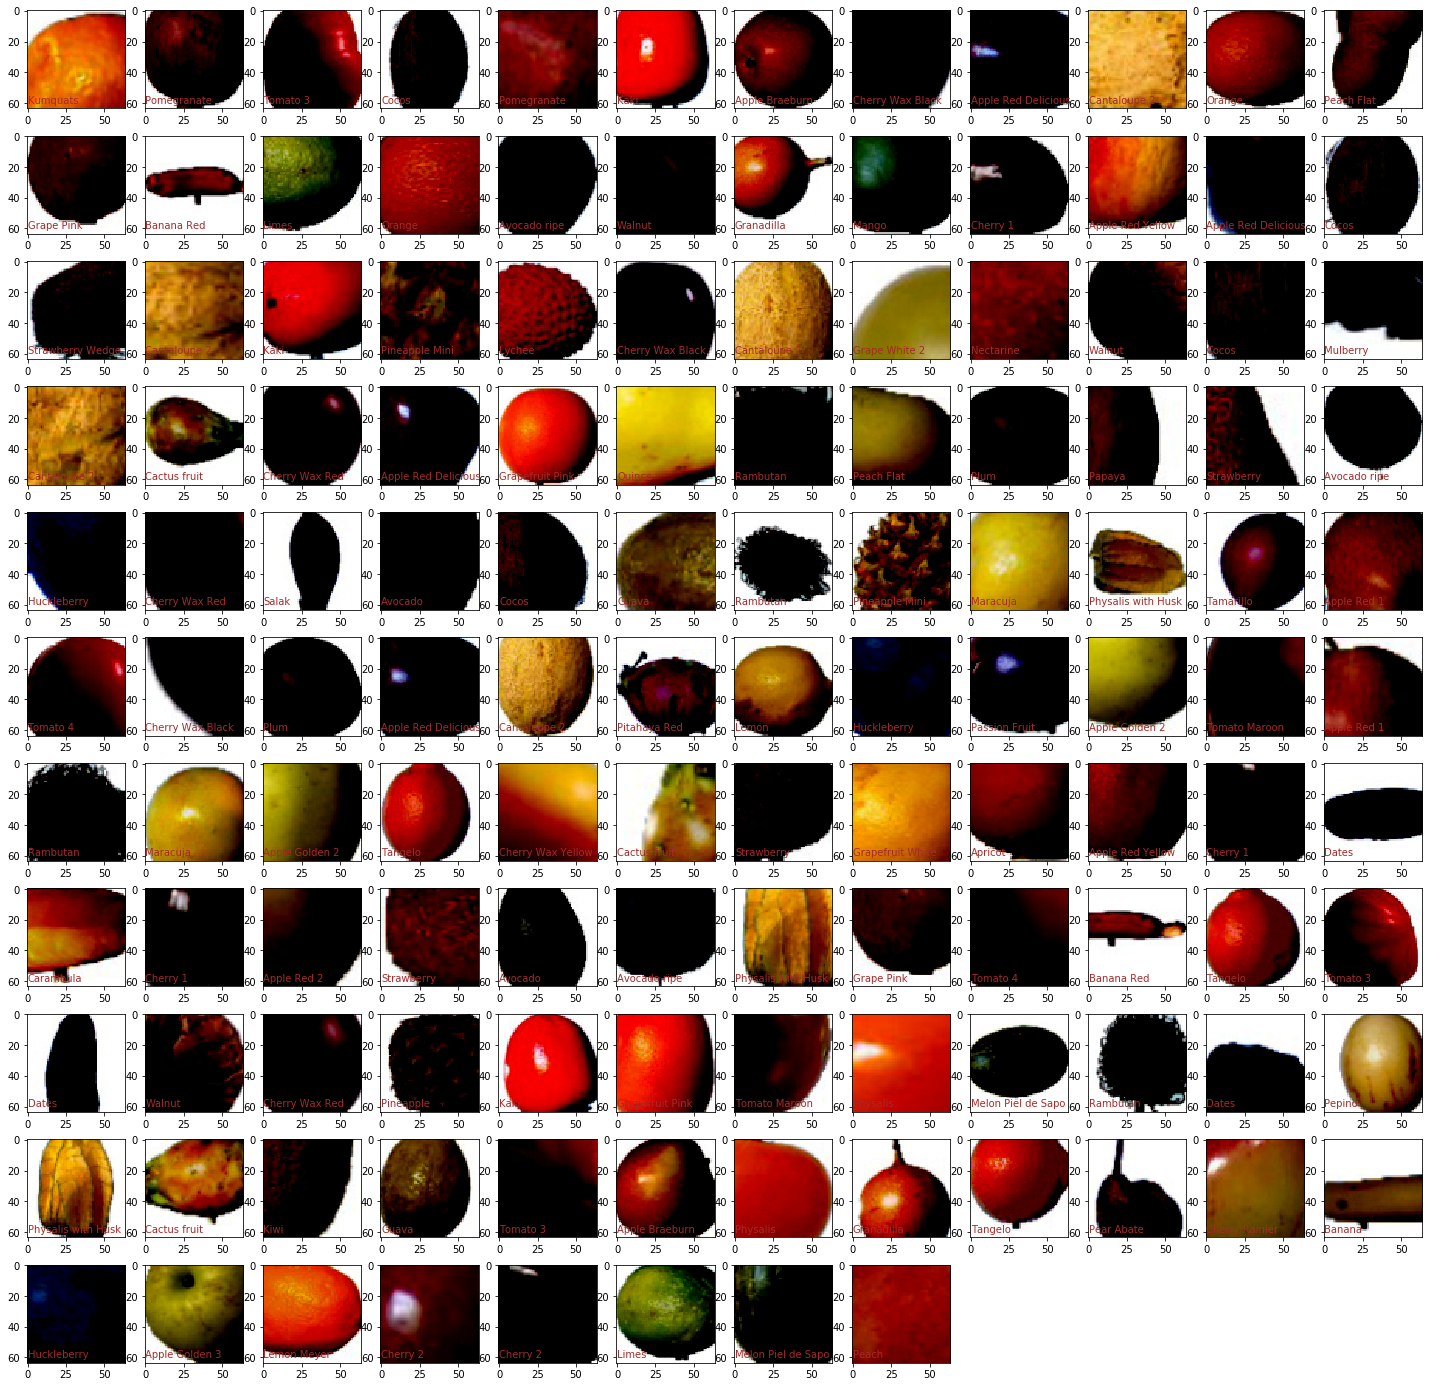

In [21]:
figsize(25,25)
eval_data, eval_target = iter(val_loader).next()
show_batch(eval_data, eval_target, eval_data.detach().argmax(1))

In [22]:
print("PyTorch version: {} | Device: {}".format(torch.__version__, device))
print("Train loader: num_batches={} | num_samples={}".format(len(train_loader), len(train_loader.sampler)))
print("Validation loader: num_batches={} | num_samples={}".format(len(val_loader), len(val_loader.sampler)))

PyTorch version: 0.4.1 | Device: cpu
Train loader: num_batches=322 | num_samples=41322
Validation loader: num_batches=109 | num_samples=13877


In [23]:
import torch.nn as nn
from torchvision.models.squeezenet import squeezenet1_1
from torch.optim import SGD


In [24]:
model = squeezenet1_1(pretrained=False, num_classes=81)
model.classifier[-1] = nn.AdaptiveAvgPool2d(1)
model = model.to(device)

/Users/lizixing/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/Users/lizixing/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [25]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [26]:
start_epoch = 0
num_epochs = 30
best_epoch = 0
best_eval_loss = float('inf')

In [27]:
def compute_eval_loss(net, loader):
    # Evaluate the model
    with torch.no_grad():
        eval_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(loader),
                                 file = sys.stdout,
                                 desc='Evaluating',
                                 total=len(loader),
                                 leave=False):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)               # Predict
            loss = criterion(outputs, labels)   # Grade / Evaluate
            eval_loss += loss.item()
    eval_loss /= len(val_loader)
    return eval_loss

In [28]:
for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(model, val_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=model.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'simplecnn-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('simplecnn-checkpoint.pth.tar', 'simplecnn-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

In [29]:
predictions = np.zeros(len(val_dataset))
targets = np.zeros(len(val_dataset))

for i  in tqdm.tnrange(len(val_dataset)):
    x, t = val_dataset[i]
    p = model(x[None,...].cuda()).cpu().argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

In [30]:
print(classification_report(targets, predictions, digits=3))

             precision    recall  f1-score   support

        0.0      1.000     1.000     1.000     13877

avg / total      1.000     1.000     1.000     13877



And let us begin

## Ignite quickstart with Fruits 360 dataset

### Engine

The base of the framework is `ignite.engine.Engine`, an object that loops a given number of times over provided data, executes a processing function and returns a result:
```python
while epoch < max_epochs:
    # run once on data
    for batch in data:
        output = process_function(batch)
```

So, a model trainer is simply an engine that loops multiple times over the training dataset and updates model parameters. 
Similarly, model evaluation can be done with an engine that runs a single time over the validation dataset and computes metrics.

In [ ]:
from ignite.engine import Engine, _prepare_batch, create_supervised_trainer

def model_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(model_update)

and that's it. A trainer is setup, so we can just simply execute `run` method and our model will be silently trained. We could also use a helper method `ignite.engine.create_supervised_trainer` to create a trainer without explicitly coding `model_update` function:
```python
from ignite.engine import create_supervised_trainer

trainer = create_supervised_trainer(model, optimizer, criterion, device)
```


> **Note:** update function should have two inputs : `engine` and `batch`



Let's add more interaction with our created trainer:
- add logging of loss function value every 50 iterations
- run offline metrics computation on a subset of the training dataset
- run metrics computation on the validation dataset once epoch is finished
- checkpoint trained model every epoch
- save 3 best models
- add LR scheduling
- add early stopping

### Events and Handlers

In order to accomplish above todo list *ignite* provides an event system that facilitates interaction at each step of the run:
- *engine is started/completed*
- *epoch is started/completed*
- *batch iteration is started/completed*

So that user can execute a custom code as an event handler.

#### Training batch loss logging

We just define a function and add this function as a handler to the trainer. There are two ways to add a handler: via `add_event_handler`, via `on` decorator:

In [ ]:
from ignite.engine import Events

log_interval = 50 
if 'cpu' in device:
    log_interval = 5 

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iteration = (engine.state.iteration - 1) % len(train_loader) + 1
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}".format(engine.state.epoch, iteration, len(train_loader), engine.state.output))


The same can be done with `add_event_handler` like this:
```python
trainer.add_event_handler(Events.ITERATION_COMPLETED, log_training_loss)
```


> **Note:** handlers can also pass `args` and `kwargs`, so in general a handler can be defined as 

```python
    def custom_handler(engine, *args, **kwargs):
        pass

    trainer.add_event_handler(Events.ITERATION_COMPLETED, custom_handler, *args, **kwargs)
    # or 
    @trainer.on(Events.ITERATION_COMPLETED, *args, **kwargs)
    def custom_handler(engine, *args, **kwargs):
        pass
```

Let's see what happens if we run the trainer for a single epoch

In [ ]:
output = trainer.run(train_loader, max_epochs=1)

Looks good! 

> add logging of loss function value every 50 iterations

Done!

#### Offline training metrics and validation metrics

Now let's add some code to compute metrics: average accuracy, precision, recall over a subset of the training dataset and validation dataset. What is *offline* training metrics and why ? By offline, I mean that we compute training metrics using a fixed model vs online when metrics are computed batchwise over model that keep changing every iteration.

At first we define metrics we want to compute:

In [ ]:
from ignite.metrics import Loss, CategoricalAccuracy, Precision, Recall


metrics = {
    'avg_loss': Loss(criterion),
    'avg_accuracy': CategoricalAccuracy(),
    'avg_precision': Precision(average=True), 
    'avg_recall': Recall(average=True)
}

Next we can define engines using a helper method `ignite.engine.create_supervised_evaluator`:

In [ ]:
from ignite.engine import create_supervised_evaluator

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

and we need to define a train subset and its data loader:

In [ ]:
import numpy as np
from torch.utils.data.dataset import Subset

random_indices = np.random.permutation(np.arange(len(train_dataset)))[:len(val_dataset)]
train_subset = Subset(train_dataset, indices=random_indices)

train_eval_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                               drop_last=True, pin_memory="cuda" in device)

Now let's define when to execute metrics computation and display results

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch
    print("Compute train metrics...")
    metrics = train_evaluator.run(train_eval_loader).metrics
    print("Training Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"
          .format(engine.state.epoch, metrics['avg_loss'], metrics['avg_accuracy'], metrics['avg_precision'], metrics['avg_recall']))
    
    
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    print("Compute validation metrics...")
    metrics = val_evaluator.run(val_loader).metrics
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"
          .format(engine.state.epoch, metrics['avg_loss'], metrics['avg_accuracy'], metrics['avg_precision'], metrics['avg_recall']))    

Let's check it again

In [ ]:
output = trainer.run(train_loader, max_epochs=1)

Nice !

> run offline metrics computation on a subset of the training dataset

> run metrics computation on the validation dataset once epoch is finished

Done !

----

##### More details



Let's explain some details in the above code. Maybe you've remarked the following
```python
metrics = train_evaluator.run(train_eval_loader).metrics
```
and you have a question what is the object returned by `train_evaluator.run(train_eval_loader)` that has `metrics` as attribute. 

Actually, `Engine` contains a structure called `State` to pass data between handlers. Basically, `State` contains information on the current 
epoch, iteration, max epochs, etc and also can be used to pass some custom data, such as metrics. Thus, the above code can be rewritten as 
```python
state = train_evaluator.run(train_eval_loader)
metrics = state.metrics
# or just
train_evaluator.run(train_eval_loader)
metrics = train_evaluator.state.metrics
```

-----

#### Learning rate scheduling

There are several ways to perform learning rate scheduling with *ignite*, here we will use the most simple one by calling `lr_scheduler.step()` every epoch:

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR


lr_scheduler = ExponentialLR(optimizer, gamma=0.8)


@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
        print("Learning rate: {}".format(lr))
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])
            print("Learning rate (group {}): {}".format(i, lr))    

#### Training checkpointing

As we move on training, we would like to store the best model, last trained model, optimizer and learning rate scheduler. With *ignite* it is not a problem, there is a special class `ModelCheckpoint` for these purposes. 

Let's use `ModelCheckpoint` handler to store the best model defined by validation accuracy. In this case we define a `score_function` that provides validation accuracy to the handler and it decides (max value - better) whether to save or not the model.

In [ ]:
from ignite.handlers import ModelCheckpoint


def score_function(engine):
    val_avg_accuracy = engine.state.metrics['avg_accuracy']
    # Objects with highest scores will be retained.
    return val_avg_accuracy


best_model_saver = ModelCheckpoint("best_models",  # folder where to save the best model(s)
                                   filename_prefix="model",  # filename prefix -> {filename_prefix}_{name}_{step_number}_{score_name}={abs(score_function_result)}.pth
                                   score_name="val_accuracy",  
                                   score_function=score_function,
                                   n_saved=3,
                                   atomic=True,  # objects are saved to a temporary file and then moved to final destination, so that files are guaranteed to not be damaged
                                   save_as_state_dict=True,  # Save object as state_dict
                                   create_dir=True, require_empty=False)

val_evaluator.add_event_handler(Events.COMPLETED, best_model_saver, {"best_model": model})

Now let's define another `ModelCheckpoint` handler to store trained model, optimizer and lr scheduler every 1000 iterations:

In [ ]:
training_saver = ModelCheckpoint("checkpoint",
                                 filename_prefix="checkpoint",
                                 save_interval=1000,
                                 n_saved=1,
                                 atomic=True,
                                 save_as_state_dict=True,
                                 create_dir=True,require_empty=False)

to_save = {"model": model, "optimizer": optimizer, "lr_scheduler": lr_scheduler} 
trainer.add_event_handler(Events.ITERATION_COMPLETED, training_saver, to_save)

We are almost done with preparations and a cherry on top

#### Early stopping

Let's add another handler to stop training if model fails to improve a score defined by a `score_function` during 10 epochs:

In [ ]:
from ignite.handlers import EarlyStopping

early_stopping = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, early_stopping)

## Run training

Now we can just call `run` method and train model during a number of epochs 

In [ ]:
max_epochs = 10

output = trainer.run(train_loader, max_epochs=max_epochs)

Let's check saved 3 best models and the checkpoint:

In [ ]:
ls best_models\

In [ ]:
!ls checkpoint/

## Inference

Let's first create a test dataloader from validation dataset such that provided batch is composed of `(samples, sample_indices)`:

In [ ]:
class TestDataset(Dataset):
    
    def __init__(self, ds):
        self.ds = ds
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        return self.ds[index][0], index

    
test_dataset = TestDataset(val_dataset)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, 
                         drop_last=False, pin_memory="cuda" in device)

With ignite to implement an engine that inference on data is simple. Similarly when we created an evaluation engine, now we modify the update function to store output results. We will also perform what is called test time augmentation (TTA).

In [ ]:
import torch.nn.functional as F
from ignite._utils import convert_tensor


def _prepare_batch(batch):
    x, index = batch
    x = convert_tensor(x, device=device)
    return x, index


def inference_update(engine, batch):
    x, indices = _prepare_batch(batch)
    y_pred = model(x)
    y_pred = F.softmax(y_pred, dim=1)
    return {"y_pred": convert_tensor(y_pred, device='cpu'), "indices": indices}

    
model.eval()
inferencer = Engine(inference_update)    

Next let's define a handler to log steps during the inference and a handler to store predictions

In [ ]:
@inferencer.on(Events.EPOCH_COMPLETED)
def log_tta(engine):
    print("TTA {} / {}".format(engine.state.epoch, n_tta))

    
n_tta = 3
num_classes = 81
n_samples = len(val_dataset)

# Array to store prediction probabilities
y_probas_tta = np.zeros((n_samples, num_classes, n_tta), dtype=np.float32)

# Array to store sample indices
indices = np.zeros((n_samples, ), dtype=np.int)
    

@inferencer.on(Events.ITERATION_COMPLETED)
def save_results(engine):
    output = engine.state.output
    tta_index = engine.state.epoch - 1
    start_index = ((engine.state.iteration - 1) % len(test_loader)) * batch_size
    end_index = min(start_index + batch_size, n_samples)
    batch_y_probas = output['y_pred'].detach().numpy()
    y_probas_tta[start_index:end_index, :, tta_index] = batch_y_probas
    if tta_index == 0:
        indices[start_index:end_index] = output['indices']

Before running the inference, we may want to load the best model from the storage:
```python
model = squeezenet1_1(pretrained=False, num_classes=64)
model.classifier[-1] = nn.AdaptiveAvgPool2d(1)  # Adapt the last average pooling to our data
model = model.to(device)

model_state_dict = torch.load("best_models/model_best_model_N_val_accuracy=0.XYZ.pth")
model.load_state_dict(model_state_dict)
```

In [ ]:
inferencer.run(test_loader, max_epochs=n_tta)

In [ ]:
%debug

Final probability aggregation can be done using mean or gmean

In [ ]:
y_probas = np.mean(y_probas_tta, axis=-1)
y_preds = np.argmax(y_probas, axis=-1)

Next step can be to create a submission using `indices` and `y_probas`. Here we will just compute accuracy on our test=validation dataset

In [ ]:
from sklearn.metrics import accuracy_score

y_test_true = [y for _, y in val_dataset]

In [ ]:
accuracy_score(y_test_true, y_preds)

### Final words

That's all for this kernel. If you liked it - please upvote. 

If you liked *ignite*, please visit its [documentation site](https://pytorch.org/ignite/), [github code](https://github.com/pytorch/ignite) and checkout [examples](https://github.com/pytorch/ignite/tree/master/examples) with `tensorboard`, `visdom` integration and how to train dcgan. Some other examples can be found [here](https://github.com/vfdev-5/ignite-examples). 

We are actively working on it and appreciate all contributions and feedbacks. As always, PR are very welcome! 



In [ ]:
# Remove output to be able to commit
!rm -R best_models/ checkpoint/ lib/